# Monte Carlo simulation of 2-D Mn-doped ZnO DMS system

In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
from numpy.random import rand
from PIL import Image
from ipywidgets import interact
import time

In [4]:
def spin_lattice(N):
    return lattice

N = 100                     # dimension 
lattice = np.zeros((N, N))  # zinc row
lattice[::2] = 2            # oxygen row

a, c = 3.27, 2.63           # lattice constants

Mn_percent = 15             # doping percentage
no_of_Mn = int(((len(lattice)**2)*Mn_percent)/100) 
Mn_arr0 = np.zeros((no_of_Mn, 2))

count = 0 
while count < no_of_Mn:
    i = np.random.randint(len(lattice))
    j = np.random.randint(len(lattice))
    if lattice[i][j] == 0:
        lattice[i][j] = np.random.choice([-1, 1])  # Mn2+ dopant
        #lattice[i][j] = 1
        Mn_arr0[count][0] = i
        Mn_arr0[count][1] = j       
    else:
        continue
    count += 1

    
lattice[lattice % 2 == 0] = 0
lattice = lattice.astype(int)    
    
Mn_arr = Mn_arr0.astype(int)
#print(lattice)

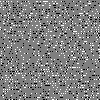

In [5]:
def lattice_field(field):
    return Image.fromarray(np.uint8((field + 1)*0.5*255))
lattice_field(spin_lattice(N))

In [6]:
def mcstep(config, beta=0.7):
    
    rand_index = np.random.choice(Mn_arr.shape[0], size = 1)
    rand_Mn = Mn_arr[rand_index, :]

    x, y, K = int(rand_Mn[0][0]), int(rand_Mn[0][1]), 4   # K is the no. of nearest neighbors
    NN_list = sorted(Mn_arr, key = lambda K: c*(K[0]-x)**2 + a*(K[1]-y)**2)[1 : K+1]
    NN = np.array(NN_list)
    
    d_val, nbs = [], [],
    for i in range(K):
        s = config[x, y]
        d_val.append(sqrt((c*(x - NN[i][0]))**2 + (a*(y - NN[i][1]))**2))
        nbs.append(config[int(NN[i][0]), int(NN[i][1])])
     
    j_val = []                   # for 10% - kf = 3.54, j0 = 0.01843, for 20% - kf = 5.01, j0 = 0.016
    for i in range(len(d_val)):
        j_val.append(((0.016*np.exp(-d_val[i]/d_val[2])*(np.sin(5.011*d_val[i])-
                    5.011*d_val[i]*np.cos(5.011*d_val[i])))/(d_val[i]**4))*13600)
    
    J = np.array(j_val)
    #print(J)
    
    #J = np.abs(np.array(j_val))
    #J = 1.22*np.ones(K)
    
    count = 0
    for i in range(Mn_arr.shape[0]):  # earlier N**2
        s = config[x, y]
        
        nb = np.dot(J, nbs)    
        dE = 2 * s * nb        # hamiltonian
        
        if dE <= 0:
            s *= -1
            count += 1    
        elif rand() < np.exp(-beta * dE):
            s *= -1
            count += 1
        config[x, y] = s
        #print(dE)
    #print("flips: ", count)
    
    return config

In [7]:
start = time.time()

def display_steps(images):
    def show1(frame = (0, len(images) - 1)):
        return lattice_field(images[frame])
    return interact(show1)

images = [spin_lattice(N)]

for j in range(10000):   # no. of MC steps
    images.append(mcstep(images[-1].copy()))
display_steps(images)

end = time.time()
print("time: ", (end-start)/60, 'min')

interactive(children=(IntSlider(value=5000, description='frame', max=10000), Output()), _dom_classes=('widget-…

time:  3.2906746745109556 min


In [8]:
def model_energy(config):   # energy of system
    
    energy, K = 0, 4     # K: no. of nearest neighbors to consider
    
    for i in range(len(config)):
        for j in range(len(config)):
            
            s2 = config[i, j]  

            if s2 == -1 or s2 == 1:
                NN_list2 = sorted(Mn_arr, key = lambda K: c * (K[0] - i)**2 + a * (K[1] - j)**2)[1 : K+1]
                NN2 = np.array(NN_list2)

                d_val2, nbs2 = [], []
                for m in range(K):
                    d_val2.append(sqrt((c * (i - NN2[m][0]))**2 + (a * (j - NN2[m][1]))**2))
                    nbs2.append(config[int(NN2[m][0]), int(NN2[m][1])])

                #j_val2 = []
                #for n in range(len(d_val2)):
                #    j_val2.append(((0.0184 * np.exp(-d_val2[n] / d_val2[2]) * (np.sin(3.54 * d_val2[n])-
                #                3.54 * d_val2[n] * np.cos(3.54 * d_val2[n]))) / (d_val2[n]**4)) * 13600)
                #J2 = np.array(j_val2)
                
                J2 = 1.22*np.ones(K)
                
                nb2 = np.dot(J2, nbs2)
                energy += -nb2 * s2
                
            else:
                continue
                                
    return energy / 4                 

In [9]:
def calcmag(config):    # magnetisation of system
    mag = np.sum(config)
    return mag

In [10]:
nt = 5            # no. of temperature points  

eqSteps = 20000   # no. of equilibrium steps
mcSteps = 5000    # no. of Monte Carlo steps

T = np.linspace(0.1, 20, nt)    # Tweak the range of temperature !!!
E, M, C, X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2 = 1.0 / (mcSteps * N * N), 1.0 / (mcSteps * mcSteps * N * N) # constants

In [ ]:
start = time.time()

for tt in range(nt):
    E1, M1, E2, M2 = 0, 0, 0, 0
    config = spin_lattice(N)
    beta = 1.0 / T[tt]
    iT2 = beta**2

#    for i in range(eqSteps):  # equilibrate
#        mcstep(config, beta)  # Monte Carlo steps

    for i in range(mcSteps):
        mcstep(config, beta)
        Ene = model_energy(config)  # calculate energy
        Mag = calcmag(config)  # calculate magnetisation

        M1 = M1 + Mag
        E1 = E1 + Ene
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene
        
    E[tt] = n1 * E1
    M[tt] = n1 * M1
    C[tt] = (n1 * E2 - n2 * E1 * E1) * iT2
    X[tt] = (n1 * M2 - n2 * M1 * M1) * beta
    
end = time.time() 
print('\n',"time:", (end - start)/60,"min")

In [ ]:
f = plt.figure(figsize=(15, 10))  # plot the calculated values

sp = f.add_subplot(2, 2, 1)
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Energy ", fontsize=20)
plt.axis('tight')

sp = f.add_subplot(2, 2, 2)
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Magnetization ", fontsize=20)
plt.axis('tight')

sp = f.add_subplot(2, 2, 3)
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Specific Heat ", fontsize=20)
plt.axis('tight')

sp = f.add_subplot(2, 2, 4)
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)
plt.axis('tight')
plt.show()